<h1>Environment</h1>

Verify that we have the correct version of astropy:

In [1]:
import astropy
print(astropy.__version__)

3.2.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import astropy.units as u

<h1>Data input</h1>

Begin by importing the helper functions in the 'proto' package:

In [3]:
import fit_functions
from specutils import Spectrum1D, SpectralRegion

Define data files: 
 - spectrum: simple 3-column ASCII file
 - wavelength regions to be included in fit: simple 2-column ASCII file

In [4]:
datafile = "../data/n5548/n5548_mean_g130mb4.asc"
regionsfile = "../data/n5548/n5548_lyalpha_sample.dat"

The read_file function reads the spectrum file and an optional regions file. 

Spectrum is returned as an object that encapsulates wavelength, flux, and error arrays. 

Regions is a list of SpectralRegion instances, one per region in the regions file.

Mask is a float numpy array with 1's for data points in regions and 0's for data points outside regions.

In [5]:
spectrum, regions, line_mask = fit_functions.read_file(datafile, regions=regionsfile)

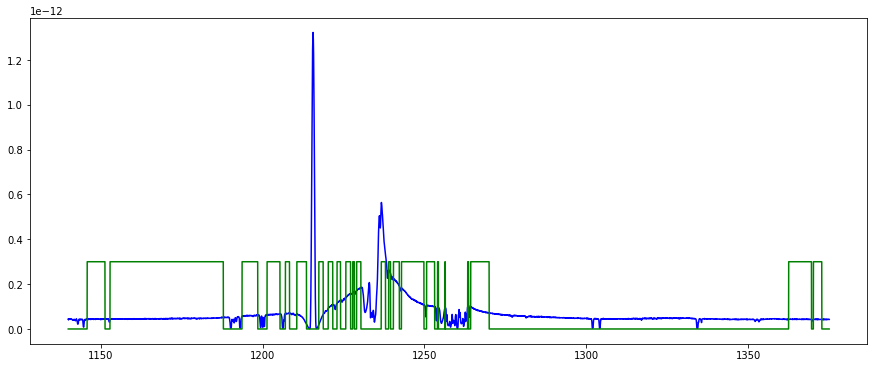

In [6]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, line_mask*3.E-13, 'g')

<h1>Line finding</h1>

Even though the spectrum carries an uncertainity attribute derived from the errors (defined in the input file), we find that the line finder performs better when supplied with a noise level computed from a featureless continuum region. The operation below replaces the internal uncertainty attribute by a new one derived from the specified region.

In [7]:
from specutils.manipulation import noise_region_uncertainty

noise_region = SpectralRegion(1155*u.AA, 1185*u.AA)
spectrum = noise_region_uncertainty(spectrum, noise_region)

Now, find lines using threshold and derivative methods:

In [8]:
from specutils.fitting import find_lines_threshold

# detection sensitivity seems to depend on the noise 
# level in a funny way. There seems tro be an optimal
# level that detects a maximum of lines. Valuesa above 
# and below that detec less lines.
NOISE = 30
lines_t = find_lines_threshold(spectrum, noise_factor=NOISE)

from specutils.fitting import find_lines_derivative

# detection is *very* sensitive to the threshold level
THRESHOLD = 0.6E-13
lines_d = find_lines_derivative(spectrum, flux_threshold=THRESHOLD)

In [9]:
print(lines_t)

line_center line_type line_center_index
  Angstrom                             
----------- --------- -----------------
   1140.306  emission                 8
 1142.47887  emission                64
  1143.7593  emission                97
 1148.84225  emission               228
 1189.27303  emission              1270
 1190.51466  emission              1302
 1190.98028  emission              1314
 1191.60109  emission              1330
 1192.53232  emission              1354
 1198.54649  emission              1509
        ...       ...               ...
 1262.37435  emission              3154
 1262.64596  emission              3161
 1263.65479  emission              3187
 1302.68872  emission              4193
 1327.17223  emission              4824
 1334.97126  emission              5025
  1336.5233  emission              5065
 1352.62577  emission              5480
 1358.17433  emission              5623
 1370.55189  emission              5942
Length = 35 rows


In [10]:
print(lines_d)

line_center line_type line_center_index
  Angstrom                             
----------- --------- -----------------
 1195.05439  emission              1419
 1195.86922  emission              1440
 1196.14082  emission              1447
 1196.41243  emission              1454
 1197.30486  emission              1477
 1197.61527  emission              1485
 1198.00328  emission              1495
 1198.19728  emission              1500
 1198.35249  emission              1504
 1198.54649  emission              1509
        ...       ...               ...
 1273.31627  emission              3436
 1273.89828  emission              3451
 1274.05349  emission              3455
  1274.3639  emission              3463
 1274.82951  emission              3475
 1275.21752  emission              3485
 1275.60553  emission              3495
 1276.45916  emission              3517
 1277.50679  emission              3544
 1277.70079  emission              3549
Length = 135 rows


Define a plotting convenience function:

In [11]:
def plot_helper(w1, w2, f1=-0.05E-12, f2=1.3E-12):
    plt.gcf().set_size_inches(15.,6.)
    plt.axis([w1, w2, f1, f2])
    plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
#     plt.plot(spectrum.spectral_axis.data, line_mask*0.3*f2, 'g')

    # noise region
    plt.plot(np.array([noise_region.lower.value, noise_region.upper.value]), np.array([0.2*f2,0.2*f2]), 'magenta')

    # found lines
    marker_style_t = dict(marker='|', color='red', s=5000)     # threshold in red
    marker_style_d = dict(marker='|', color='magenta', s=5000) # derivative in magenta
    plt.scatter(lines_t['line_center'], (np.ones(len(lines_t['line_center']))*0.8*f2), **marker_style_t)
    plt.scatter(lines_d['line_center'], (np.ones(len(lines_d['line_center']))*0.5*f2), **marker_style_d)

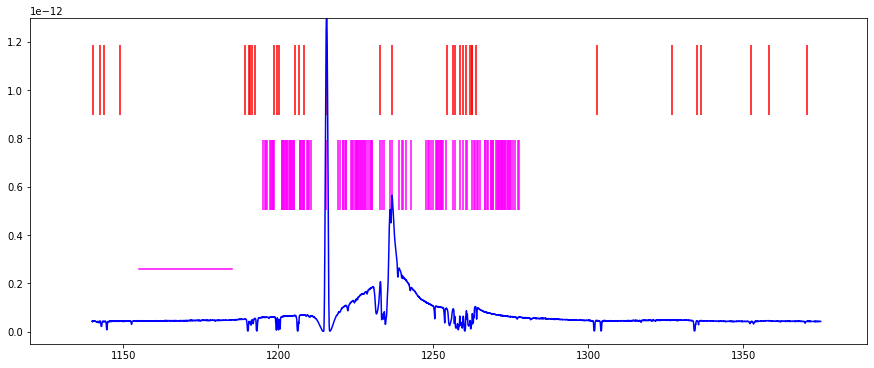

In [12]:
plot_helper(1120., 1390.)

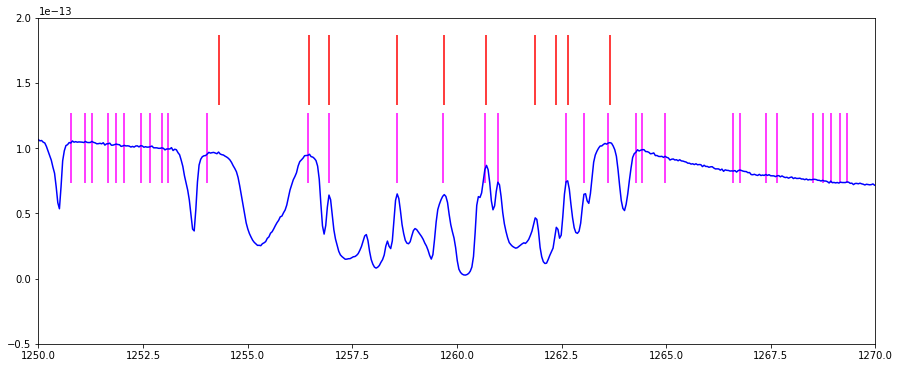

In [13]:
plot_helper(1250., 1270., f1=-0.05E-12, f2=2.E-13)

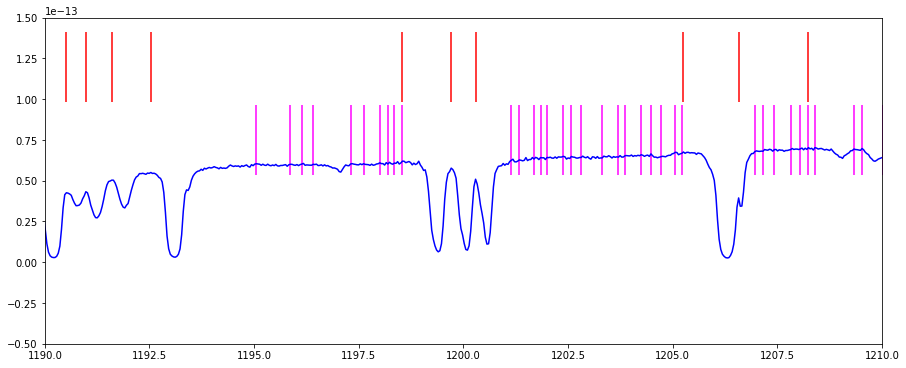

In [14]:
plot_helper(1190., 1210., f1=-0.05E-12, f2=1.5E-13)

<h1>Fitting</h1>

As previously, we build a compound model to act as first guess (this is explained in notebook specfit_demo_specutils.ipynb).

In [15]:
import n5548_models_specfit as models
compound_model = models.model1

print(compound_model)

Model: CompoundModel21
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20]
Components: 
    [0]: <PowerLaw1D(amplitude=0., x_0=1000., alpha=0.4819233)>

    [1]: <Gaussian1D(amplitude=0., mean=1195.006, stddev=1.45817626)>

    [2]: <Gaussian1D(amplitude=0., mean=1226.392, stddev=1.49647424)>

    [3]: <Gaussian1D(amplitude=0., mean=1236.729, stddev=0.4475623)>

    [4]: <Gaussian1D(amplitude=0., mean=1235.996, stddev=1.50819328)>

    [5]: <Gaussian1D(amplitude=0., mean=1235.138, stddev=5.31938877)>

    [6]: <Gaussian1D(amplitude=0., mean=1231.589, stddev=14.1876428)>

    [7]: <Gaussian1D(amplitude=0., mean=1237.643, stddev=31.8761801)>

    [8]: <Gaussian1D(amplitude=0., mean=1259.753, stddev=0.4558945)>

    [9]: <Gaussian1D(amplitude=0., mean=1263.803, stddev=0.45736016)>

    [10]: <Gaussian1D(amplitude=0., mean=1259.533, stddev=1.536913

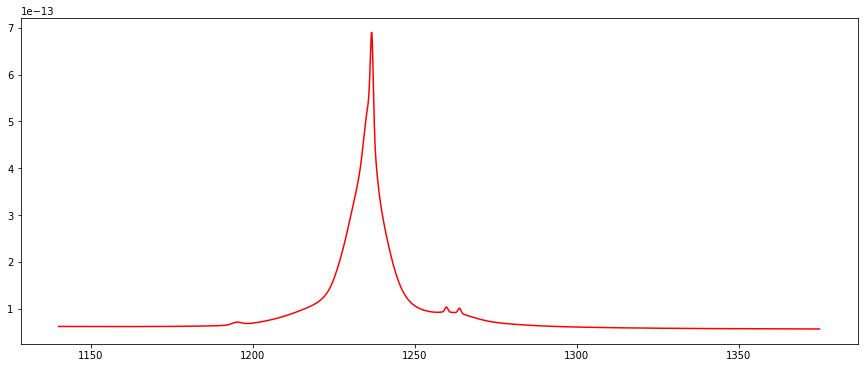

In [16]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')

The actual fitting then is carried out by the fit_lines function.

In [17]:
import astropy.modeling.fitting as fitting
from specutils.fitting import fit_lines
import time

# weight array contains both mask and uncertainties
w = line_mask.copy()
w /= spectrum.uncertainty.array
max_w = np.max(w)
w /= max_w

start_time = time.time()

# pass an explicit fitter so we can check for diagnostics
fitter = fitting.LevMarLSQFitter()
fit_result = fit_lines(spectrum, compound_model, fitter=fitter, weights=w, maxiter=10000)

end_time = time.time()

print(end_time - start_time)

/Users/busko/Projects/miniconda3/envs/specut/lib/python3.7/site-packages/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


50.777263164520264


In [18]:
print(fitter.fit_info['message'])

Number of calls to function has reached maxfev = 10000.


The result is an instance of QuantityModel. We use it's unitless version:

In [19]:
print(fit_result.unitless_model)

Model: CompoundModel41
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20]
Components: 
    [0]: <PowerLaw1D(amplitude=0., x_0=1000., alpha=0.4819233)>

    [1]: <Gaussian1D(amplitude=0., mean=1195.006, stddev=1.45817626)>

    [2]: <Gaussian1D(amplitude=0., mean=1226.392, stddev=1.49647424)>

    [3]: <Gaussian1D(amplitude=0., mean=1236.729, stddev=0.4475623)>

    [4]: <Gaussian1D(amplitude=0., mean=1235.996, stddev=1.50819328)>

    [5]: <Gaussian1D(amplitude=0., mean=1235.138, stddev=5.31938877)>

    [6]: <Gaussian1D(amplitude=0., mean=1231.589, stddev=14.1876428)>

    [7]: <Gaussian1D(amplitude=0., mean=1237.643, stddev=31.8761801)>

    [8]: <Gaussian1D(amplitude=0., mean=1259.753, stddev=0.4558945)>

    [9]: <Gaussian1D(amplitude=0., mean=1263.803, stddev=0.45736016)>

    [10]: <Gaussian1D(amplitude=0., mean=1259.533, stddev=1.536913

<h1>Plots</h1>

<h3>Input and output compound models</h3>

In [20]:
fit_result = fit_result.unitless_model

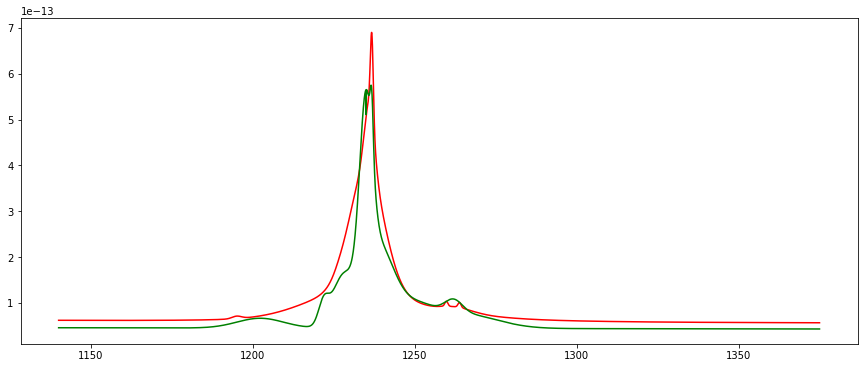

In [21]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')
fitted_spectrum = fit_result(spectrum.spectral_axis.data)
plt.plot(spectrum.spectral_axis.data, fitted_spectrum, 'g')

<h3>Input compound model overploted on spectrum</h3>

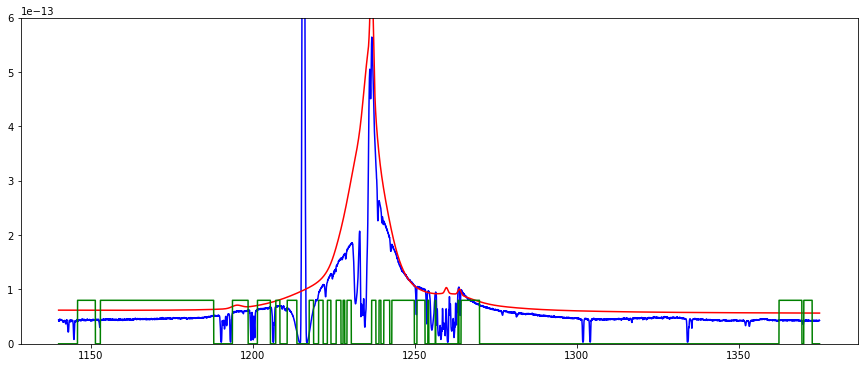

In [22]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')
plt.plot(spectrum.spectral_axis.data, line_mask*8.E-14, 'g')

<h3>Fit result overploted on input spectrum</h3>

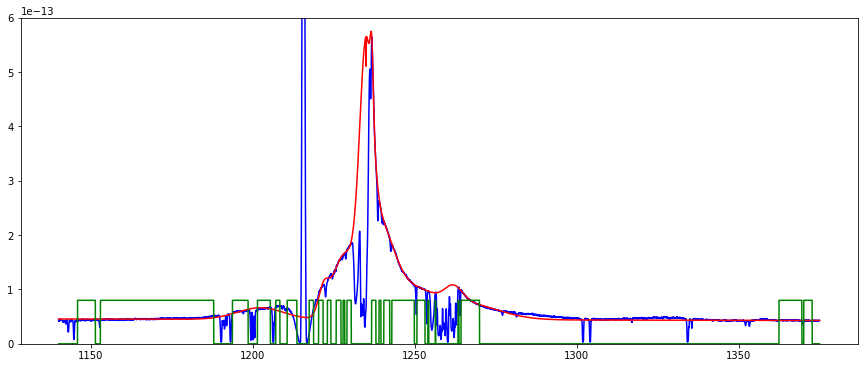

In [23]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, fitted_spectrum, 'r')
plt.plot(spectrum.spectral_axis.data, line_mask*8.E-14, 'g')

<h3>Residuals</h3>

input spectrum - input model: plotted in yellow

input spectrum - fitted model: plotted in blue

In [24]:
residuals = spectrum.flux.data - fitted_spectrum
original_residuals = spectrum.flux.data - compound_model(spectrum.spectral_axis.data)

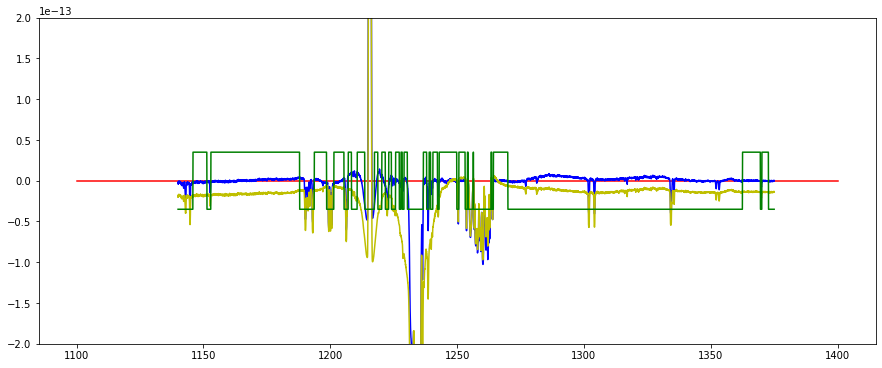

In [25]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(-2.e-13, 2.e-13)
plt.plot([1100., 1400], [0., 0.], 'r')
plt.plot(spectrum.spectral_axis.data, residuals, 'b')
plt.plot(spectrum.spectral_axis.data, original_residuals, 'y')
plt.plot(spectrum.spectral_axis.data, (line_mask-0.5)*7.E-14, 'g')

<h3>Detail of residuals plot</h3>

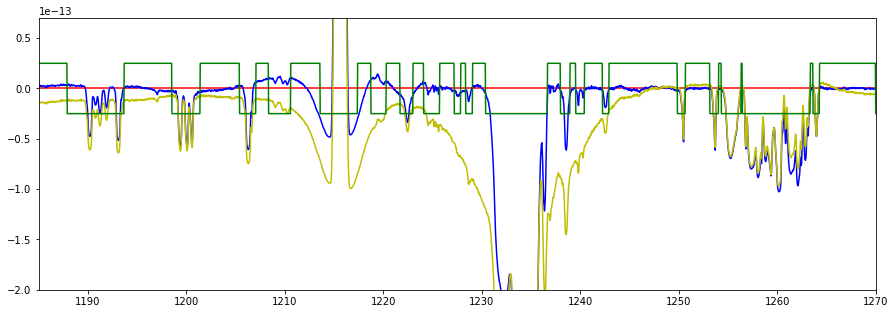

In [26]:
plt.gcf().set_size_inches(15.,5.)
plt.xlim(1185., 1270.)
plt.ylim(-2.e-13, 0.7e-13)
plt.plot([1185., 1270], [0., 0.], 'r')
plt.plot(spectrum.spectral_axis.data, residuals, 'b')
plt.plot(spectrum.spectral_axis.data, original_residuals, 'y')
plt.plot(spectrum.spectral_axis.data, (line_mask-0.5)*5.E-14, 'g')